In [1]:
import numpy as np
import os
import sys
import pandas as pd


import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from GlobalUtils import GlobalUtils
utils = GlobalUtils()
os.chdir(utils.base_dir)
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler


helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint


1 Physical GPUs, 1 Logical GPUs


In [2]:

import numpy as np
import pandas as pd
import json
import h5py
import seaborn as sns
import os
import csv
import sys
from sklearn.model_selection import train_test_split

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)
from GlobalUtils import GlobalUtils
glob_utils = GlobalUtils()

        
        
class LoadData():
    
    def __init__(self, earth_explo_only = False, noise_earth_only = False, noise_not_noise = False, 
                 downsample = False, upsample = False, frac_diff = 1, seed = None, subsample_size = 1,
                 balance_non_train_set = False, use_true_test_set = False, load_everything = False, 
                 load_first_batch = False, even_balance = False):
        self.seed = seed
        np.random.seed(self.seed)
        self.earth_explo_only = earth_explo_only
        self.noise_earth_only = noise_earth_only
        self.noise_not_noise = noise_not_noise
        self.downsample = downsample
        self.upsample = upsample
        self.frac_diff = frac_diff
        self.subsample_size = subsample_size
        self.balance_non_train_set = balance_non_train_set
        self.use_true_test_set = use_true_test_set
        # If true, then the class distribution will be equal to 1/num_classes.
        self.even_balance = even_balance
        
        self.csv_folder = glob_utils.csv_dir
        #self.csv_folder = os.path.join('/media/tord/T7', 'Thesis_ssd','MasterThesis3.0','csv_folder')
        #self.data_csv_name = 'full_no_test.csv'
        self.data_csv_name = glob_utils.data_csv_name
        if load_first_batch:
            #self.data_csv_name = 'full_batch_1.csv'
            self.data_csv_name = utils.batch_1_csv_name
            assert not load_everything, "Load everything should be False when using the first batch. A test set has not been generated for this dataset"
        if load_everything:
            #self.data_csv_name = 'event_paths_no_nan_no_induced.csv'
            print("Loading all of second batch. Including the test data.")
            self.data_csv_name = glob_utils.no_nan_no_induced_csv_name
            self.full_ds = self.csv_to_numpy(self.data_csv_name, self.csv_folder)
            self.create_label_dict()
        else:
            self.full_ds = self.csv_to_numpy(self.data_csv_name, self.csv_folder)
            self.create_label_dict()
            self.load_data()
            if self.use_true_test_set:
                self.test_csv_name = glob_utils.test_csv_name
                self.true_test_ds = self.csv_to_numpy(self.test_csv_name, self.csv_folder)
                print("WARNING!")
                print("You are using the true test set.")
                print("THIS SHOULD ONLY BE USED ONCE")
                print("If this is an error, please set use_true_test_set = False and reload the kernel")

            if sum([self.earth_explo_only, self.noise_earth_only, self.noise_not_noise]) > 1:
                raise Exception("Invalid load data arguments.")
        print("\n")
        self.print_data_info()
        
    """
    Todo:
     - Want timeAug to fit to each data set, not the entire thing. Should speed things up.
         - Therefore, want to map redundancy to each set, seperately.
     - Want to split so that events in training is not in validation/test

    """

    def load_data(self):
        if not self.use_true_test_set:
            if self.noise_not_noise:
                self.load_noise_not_noise()
            if self.earth_explo_only:
                self.load_earth_explo_only()
            if self.noise_earth_only:
                raise Exception("Not implemented noise earth only. Seems unecessary")
        else:
            raise Exception("Not allowed to use true test set yet. Needs implementation")
        
    def load_noise_not_noise(self):
        noise = self.full_ds[self.full_ds[:,1] == "noise"]
        explosions = self.full_ds[self.full_ds[:,1] == "explosion"]
        earthquakes = self.full_ds[self.full_ds[:,1] == "earthquake"]
        
        # Unique noise split
        train_noise, val_test_noise = train_test_split(noise, test_size = 0.2, random_state = self.seed)
        val_noise, test_noise = train_test_split(val_test_noise, test_size = 0.4, random_state = self.seed)
        
        #Unique explosion split
        train_explosions, val_test_explosions = train_test_split(explosions, test_size = 0.2, random_state = self.seed)
        val_explosions, test_explosions = train_test_split(val_test_explosions, test_size = 0.4, random_state = self.seed)
        
        #Unique earthquake split
        train_earthquakes, val_test_earthquakes = train_test_split(earthquakes, test_size = 0.2, random_state = self.seed)
        val_earthquakes, test_earthquakes = train_test_split(val_test_earthquakes, test_size = 0.4, random_state = self.seed)
        
        # Combining so that events are not duplicated in the splits
        self.train = np.concatenate((train_noise, train_explosions, train_earthquakes))
        self.val = np.concatenate((val_noise, val_explosions, val_earthquakes))
        self.test = np.concatenate((test_noise, test_explosions, test_earthquakes))
        
        # Combining so that events are not duplicated in the splits
        self.train = np.concatenate((train_noise, train_explosions, train_earthquakes))
        self.val = np.concatenate((val_noise, val_explosions, val_earthquakes))
        self.test = np.concatenate((test_noise, test_explosions, test_earthquakes))
        # Up and down sampling 
        self.train = self.balance_ds(self.train, self.downsample, self.upsample, frac_diff = self.frac_diff)
        if self.balance_non_train_set:
            self.val = self.balance_ds(self.val, self.downsample, self.upsample, frac_diff = self.frac_diff)
            self.test = self.balance_ds(self.test, self.downsample, self.upsample, frac_diff = self.frac_diff)
        else:
            # Shuffles the data if not
            self.val = self.balance_ds(self.val, False, False, frac_diff = self.frac_diff)
            self.test = self.balance_ds(self.test, False, False, frac_diff = self.frac_diff)

        if self.even_balance:
            self.train = self.even_label_occurances(self.train)
            if self.balance_non_train_set:
                self.val = self.even_label_occurances(self.val)
                self.test = self.even_label_occurances(self.test)

        self.train = self.train[np.random.choice(self.train.shape[0], int(len(self.train)*self.subsample_size), replace = False)]
        self.val = self.val[np.random.choice(self.val.shape[0], int(len(self.val)*self.subsample_size), replace = False)]
        self.test = self.test[np.random.choice(self.test.shape[0], int(len(self.test)*self.subsample_size), replace = False)]

        # Mapping redundnad samples for time augmentor
        self.train = self.map_redundancy(self.train, "train")
        self.val = self.map_redundancy(self.val, "validation")
        self.test = self.map_redundancy(self.test, "test")
        self.full_ds = np.concatenate((self.train, self.val, self.test))
        
        self.noise_ds = self.train[self.train[:,1] == "noise"]

            
    def load_earth_explo_only(self):
        noise = self.full_ds[self.full_ds[:,1] == "noise"]
        explosions = self.full_ds[self.full_ds[:,1] == "explosion"]
        earthquakes = self.full_ds[self.full_ds[:,1] == "earthquake"]
        
        # Unique noise split
        train_noise, val_test_noise = train_test_split(noise, test_size = 0.2, random_state = self.seed)
        val_noise, test_noise = train_test_split(val_test_noise, test_size = 0.4, random_state = self.seed)
        
        #Unique explosion split
        train_explosions, val_test_explosions = train_test_split(explosions, test_size = 0.2, random_state = self.seed)
        val_explosions, test_explosions = train_test_split(val_test_explosions, test_size = 0.4, random_state = self.seed)
        
        #Unique earthquake split
        train_earthquakes, val_test_earthquakes = train_test_split(earthquakes, test_size = 0.2, random_state = self.seed)
        val_earthquakes, test_earthquakes = train_test_split(val_test_earthquakes, test_size = 0.4, random_state = self.seed)
        
        # Combining so that events are not duplicated in the splits
        self.train = np.concatenate((train_explosions, train_earthquakes))
        self.val = np.concatenate((val_explosions, val_earthquakes))
        self.test = np.concatenate((test_explosions, test_earthquakes))
        
        # Up and down sampling 
        self.train = self.balance_ds(self.train, self.downsample, self.upsample, frac_diff = self.frac_diff)
        if self.balance_non_train_set:
            self.val = self.balance_ds(self.val, self.downsample, self.upsample, frac_diff = self.frac_diff)
            self.test = self.balance_ds(self.test, self.downsample, self.upsample, frac_diff = self.frac_diff)
        else:
            # Shuffles the data if not
            self.val = self.balance_ds(self.val, False, False, frac_diff = self.frac_diff)
            self.test = self.balance_ds(self.test, False, False, frac_diff = self.frac_diff)

        if self.even_balance:
            self.train = self.even_label_occurances(self.train)
            if self.balance_non_train_set:
                self.val = self.even_label_occurances(self.val)
                self.test = self.even_label_occurances(self.test)

        self.train = self.train[np.random.choice(self.train.shape[0], int(len(self.train)*self.subsample_size), replace = False)]
        self.val = self.val[np.random.choice(self.val.shape[0], int(len(self.val)*self.subsample_size), replace = False)]
        self.test = self.test[np.random.choice(self.test.shape[0], int(len(self.test)*self.subsample_size), replace = False)]

        # Mapping redundnad samples for time augmentor
        self.train = self.map_redundancy(self.train, "train")
        self.val = self.map_redundancy(self.val, "validation")
        self.test = self.map_redundancy(self.test, "test")
        self.full_ds = np.concatenate((self.train, self.val, self.test))
        
        # Create noise_ds. 
        # Create zero redundancy column
        train_noise = train_noise[np.random.choice(train_noise.shape[0], int(len(train_noise)*self.subsample_size), replace = False)]
        zero_column = np.zeros((len(train_noise), 1), dtype = np.int)
        self.noise_ds = np.hstack((train_noise, zero_column))
    
                
    
    def create_label_dict(self):
        # Method which produces the dictionary for labels. This is used in order to disguise labels during training.
        if self.earth_explo_only:
            self.label_dict = {'earthquake' : 0, 'explosion' : 1}
        elif self.noise_earth_only:
            self.label_dict = {'earthquake' : 0, 'noise' : 1}
        elif self.noise_not_noise:
            self.label_dict = { 'noise': 0, 'earthquake' : 1, 'explosion' : 1}
        else:
            self.label_dict = {'earthquake' : 0, 'noise' : 1, 'explosion' : 2, 'induced' : 3}
    
    def get_datasets(self):
        return self.train, self.val, self.test  
        
    def csv_to_numpy(self, data_csv, csv_folder):
        with open(csv_folder + '/' + data_csv) as file:
            file_list = np.array(list(file))
            dataset = np.empty((len(file_list), 2), dtype=object)
            for idx, event in enumerate(file_list):
                path, label = event.split(',')
                dataset[idx][0] = path.rstrip()
                dataset[idx][1] = label.rstrip()
            file.close()
        return dataset
    
    def downsample_label(self, target_label, ds, n_samples):
        # Method which produces n_samples of the targeted label, and returns the dataset unchanged but with n_samples of the targeted label.
        target_array = np.array([x for x in ds if x[1] == target_label], dtype = object)
        down_ds = np.array([y for y in ds if y[1] != target_label], dtype = object)
        np.random.seed(self.seed)
        down_ds = np.concatenate((down_ds, target_array[np.random.choice(target_array.shape[0], n_samples, replace = True)]))
        return np.array(down_ds)

    def upsample_label(self, target_label, ds, n_samples):
        # Seemingly equivalent to downsample_label (?)
        target_array = np.array([x for x in ds if x[1] == target_label])
        up_ds = [y for y in ds if y[1] != target_label]
        np.random.seed(self.seed)
        up_ds = np.concatenate((up_ds, target_array[np.random.choice(target_array.shape[0], n_samples, replace = True)]))
        return np.array(up_ds)

    def frac_diff_n_samples(self, frac_diff, min_counts, max_counts):
        # Returns the difference between the most occuring label and the least occuring label, multiplied by some fraction, and added to the number of the least occuring label.
        # Potentially a really stupid idea which is now implemented. Can be omitted by setting frac diff = 1 
        diff = max_counts - min_counts
        n_samples = int(min_counts + diff*frac_diff)
        return n_samples

    def balance_ds(self, ds, downsample, upsample, frac_diff = 0):
        # Downsamples the two most occuring labels, and upsamples the most occuring label.
        unique_labels, counts = np.unique(ds[:,1], return_counts = True)
        nr_classes = len(unique_labels)
        if downsample:
            # Downsamples by first reducing the largest class, then the second class.
            for i in range(nr_classes-1):
                unique_labels, counts = np.unique(ds[:,1], return_counts = True)
                most_occuring_label = unique_labels[np.where(counts == max(counts))]
                n_samples_frac_diff = self.frac_diff_n_samples(frac_diff, min(counts), max(counts))
                ds = self.downsample_label(most_occuring_label, ds, n_samples_frac_diff)
        if upsample:
            if frac_diff != 0:
                unique_labels, counts = np.unique(ds[:,1], return_counts = True)
                least_occuring_label = unique_labels[np.where(counts == min(counts))]
                n_samples_for_balance = max(counts)
                ds = self.upsample_label(least_occuring_label, ds, n_samples_for_balance)
        np.random.seed(self.seed)
        np.random.shuffle(ds)
        return ds

    def even_label_occurances(self, ds):
        # In cases where labels are disguised as something else, this method will even them out so that the label distribution is even. 
        num_classes = len(set(self.label_dict.values()))
        print(num_classes, len(set(self.label_dict.keys())))
        if num_classes != len(set(self.label_dict.keys())):
            print("Balancing due to disguised labels.")
            print("This functions barely works, and is a piece of shit that should not be trusted. Only works because noise has id: 0")
            ids = self.label_dict.values()
            most_occuring_id = max(ids)
            least_occuring_id = min(ids)
            label_count_dict = {}
            for label, id in self.label_dict.items():
                label_count_dict[label] = len(ds[ds[:,1] == label])
            print(label_count_dict)
            # Want the labels which share id, to combined have the same number of events of the event with the unique id.
            for label, id in self.label_dict.items():
                if id == most_occuring_id:
                    pure_label_ds = ds[ds[:,1] == label]
                    ds_without_label = ds[ds[:,1] != label]
                    ds = np.concatenate((ds_without_label, pure_label_ds[np.random.choice(pure_label_ds.shape[0], label_count_dict[label]//num_classes, replace = False)]))
        return ds
    
    def get_label_dict(self):
        return self.label_dict
    
    def map_redundancy(self, ds, set_name):
        # Creates a redundancy index which distinguishes events which are sampled multiple times.
        # Primarily used in timeAugmentation in order to create unique augmentations of otherwise identical events.
        # This only works if we are upsampling EARTHQUAKES (NOTHING ELSE)!
        new_column = np.zeros((len(ds), 1), dtype = np.int8)
        mapped_ds = np.hstack((ds, new_column))
        earth_ds = ds[ds[:,1] == "earthquake"]
        unique_earth_paths = set(earth_ds[:,0])
        nr_unique_earth_paths = len(unique_earth_paths)
        for idx, path in enumerate(unique_earth_paths):
            self.progress_bar(idx + 1, nr_unique_earth_paths, f"Mapping {set_name} redundancy: ")
            nr_repeats = len(earth_ds[earth_ds[:,0] == path])
            label = earth_ds[earth_ds[:,0] == path][0][1]
            repeating_indexes = np.where(ds[ds[:,0] == path][:,0][0] == ds[:,0])[0]
            current_index = 0
            if len(repeating_indexes) > 1:
                for event in earth_ds[earth_ds[:,0] == path]:
                    mapped_ds[repeating_indexes[current_index]][0] = path
                    mapped_ds[repeating_indexes[current_index]][1] = label
                    mapped_ds[repeating_indexes[current_index]][2] = current_index
                    current_index += 1
        print("\n")
        return mapped_ds

    def progress_bar(self, current, total, text, barLength = 40):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('%s: [%s%s] %d %%' % (text, arrow, spaces, percent), end='\r')

    def print_data_info(self):
        if self.earth_explo_only:
            print("Loaded explosion and earthquake dataset:")
        if self.noise_not_noise:
            print("Loaded noise non-noise dataset.")
        if self.even_balance:
            print("Evenly balanced among classes in the train set.")
        if self.balance_non_train_set:
            print("As well as non train sets.")
        print("Distribution (Label: (counts, proportion)) of")
        print("Train ds:")
        labels, counts = np.unique(self.train[:,1], return_counts = True)
        print(self.generate_dist_string_EE(labels, counts))
        print("Val ds:")
        labels, counts = np.unique(self.val[:,1], return_counts = True)
        print(self.generate_dist_string_EE(labels, counts))
        print("Test ds:")
        labels, counts = np.unique(self.test[:,1], return_counts = True)
        print(self.generate_dist_string_EE(labels, counts))

        
        
    def generate_dist_string_EE(self, labels, counts):
        string = ""
        for i in range(len(labels)):
            string += f"{labels[i]}: ({counts[i]}, {np.round(counts[i]/np.sum(counts), decimals = 4)})  "
            if i != len(labels) - 1:
                string += "|  "
        return string
            


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras import utils
from obspy import Stream, Trace, UTCDateTime
import time

import os
import sys
classes_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(classes_dir)
#from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes.Scaling.RobustScalerFitter import RobustScalerFitter

class RamLoader:
    def __init__(self, loadData, handler, use_time_augmentor = False, use_noise_augmentor = False, scaler_name = None, 
                filter_name = None, band_min = 2.0, band_max = 4.0, highpass_freq = 0.1, load_test_set = False, meier_load = False):
        self.loadData = loadData
        self.handler = handler
        self.train_ds, self.val_ds, self.test_ds = self.loadData.get_datasets()
        self.noise_ds = self.loadData.noise_ds
        self.use_time_augmentor = use_time_augmentor
        self.use_noise_augmentor = use_noise_augmentor
        self.scaler_name = scaler_name
        self.filter_name = filter_name
        self.band_min = band_min
        self.band_max = band_max
        self.highpass_freq = highpass_freq
        self.load_test_set = load_test_set
        self.num_classes = len(set(handler.loadData.label_dict.values()))
        self.meier_load = meier_load

    

    """
    Time, filter, scaler, noise:
    1. timeaug
    2. filter
    3 scaler
    4. noise
    Time, scaler, noise:
    1. timeaug
    2. scaler
    3. noise
    filter, scaler, noise:
    1. filter
    2. scaler
    3. noise
    

    PROBLEMS: 
    - Scaling is different if a filter is used. If a filter is used, we need to load the data into ram,
    detrend/filter it, as well as time augment it, prior to fitting the scaler.

    - Initially this class was initiated once for each dataset. Since we are fitting timeAug and scalers
    within this class now, we need to do everything in on initiation of the class

    These solutions should be resolved.
    """
    
    def fit_timeAug(self, ds, dataset_name):
        timeAug = None
        if self.use_time_augmentor:
            timeAug = TimeAugmentor(self.handler, ds, dataset_name = dataset_name, seed = self.loadData.seed)
            timeAug.fit()
            print("\n")
        return timeAug
    
    
    
    def load_to_ram(self):
        start = time.time()
        # Starting with fitting potential time augmentor
        self.train_timeAug = self.fit_timeAug(self.train_ds, "train")
        self.val_timeAug = self.fit_timeAug(self.val_ds, "validation")
        if self.load_test_set:
            self.test_timeAug = self.fit_timeAug(self.test_ds, "test")
            
        # If we want to use noise augmentor while we arent classifying noise,
        # we need to fit time augmentor for the noise samples.
        if self.loadData.earth_explo_only and self.use_noise_augmentor:
            self.noise_timeAug = self.fit_timeAug(self.noise_ds, "noise set")
            
        # Step one, load traces and apply time augmentation and/or detrend/highpass
        train_trace, train_label = self.stage_one_load(self.train_ds, self.train_timeAug, 0)
        val_trace, val_label = self.stage_one_load(self.val_ds, self.val_timeAug, 1)
        if self.load_test_set:
            test_trace, test_label = self.stage_one_load(self.test_ds, self.test_timeAug, 2)
        
        
        # The scaler is dependent on timeAug and highpasss/detrend, so must now fit the scaler:
        self.scaler = self.fit_scaler(train_trace, self.train_timeAug)
        
        # When using noise augmentor and earth_explo_only, a scaler for the noise data needs to be fitted.
        # This is temporarily memory expensive with the current solution.
        if self.use_noise_augmentor and self.loadData.earth_explo_only:
            noise_trace, _ = self.stage_one_load(self.noise_ds, self.noise_timeAug, 3)
            self.noise_scaler = self.fit_scaler(noise_trace, self.noise_timeAug)
            if self.scaler_name == "robust":
                for idx, trace in enumerate(noise_trace):
                    trace = self.noise_scaler.fit_transform(trace)
            self.noiseAug = self.fit_noiseAug(self.loadData, noise_trace)
            del noise_trace
            
        
        # Using the fitted scaler, we transform the traces:
        train_trace, train_label = self.stage_two_load(train_trace, train_label, 0, self.meier_load)
        val_trace, val_label = self.stage_two_load(val_trace, val_label, 1, self.meier_load)
        if self.load_test_set:
            test_trace = self.stage_two_load(test_trace, test_label, 2, self.meier_load)
        
        if self.use_noise_augmentor and not self.loadData.earth_explo_only:
            # Need to get only the noise traces:
            if (self.meier_load and self.num_classes == 2) or self.num_classes > 2:
                noise_indexes = np.where(train_label[:,self.loadData.label_dict["noise"]] == 1)
            if not self.meier_load and self.num_classes == 2:
                noise_indexes = np.where(train_label == self.loadData.label_dict["noise"])
            noise_traces = train_trace[noise_indexes]
            self.noiseAug = self.fit_noiseAug(self.loadData, noise_traces)
        print("\n")
        print("Completed loading to RAM")
        end = time.time()
        print(f"Process took {int((end-start))} seconds.")
        if self.load_test_set:
            return train_trace, train_label, val_trace, val_label, test_trace, test_label, self.noiseAug
        return train_trace, train_label, val_trace, val_label, self.noiseAug
    
    
    
    
    
    def fit_scaler(self, traces, timeAug):
        scaler = None
        if self.scaler_name != None:
            if self.scaler_name == "minmax":
                scaler = MinMaxScalerFitter(self.train_ds, timeAug)
                scaler.fit_scaler_ram(traces)
                scaler = scaler.scaler
            elif self.scaler_name == "standard":
                scaler = StandardScalerFitter(self.train_ds, timeAug)
                scaler.fit_scaler_ram(traces)
                scaler = scaler.scaler
            elif self.scaler_name == "robust":
                scaler = RobustScalerFitter(self.train_ds, timeAug)
                print("Fit process of robust scaler skipped as unecessary.")
            elif self.scaler_name != "minmax" or self.scaler_name != "standard" or self.scaler_name != "robust":
                raise Exception(f"{self.scaler_name} is not implemented.")
            print("\n")
        return scaler

    def fit_noiseAug(self, loadData, noise_traces):
        noiseAug = None
        if self.use_noise_augmentor:
            noiseAug = NoiseAugmentor(loadData, noise_traces)
        return noiseAug
            
    def get_substage(self, substage):
        if substage == 0:
            return "training set"
        if substage == 1:
            return "validation set"
        if substage == 2:
            return "test set"
        if substage == 3:
            return "noise set"
        return ""
    
    def stage_one_load(self, ds, timeAug, substage):
        loaded_label = np.empty((len(ds), 1))
        loaded_trace = np.empty((self.handler.get_trace_shape_no_cast(ds, self.use_time_augmentor)))
        num_events = len(ds)
        bar_text =  self.stage_one_text(substage)
        for i in range(num_events):
            self.progress_bar(i+1, num_events, bar_text)
            loaded_label[i] = self.handler.label_dict.get(ds[i][1])
            # timeAug, highpass and detrend.
            if self.filter_name != None or self.use_time_augmentor:
                if self.filter_name != None and self.use_time_augmentor:
                    loaded_trace[i] = timeAug.augment_event(ds[i][0], ds[i][2])
                    info = self.handler.path_to_trace(ds[i][0])[1]
                    loaded_trace[i] = self.apply_filter(loaded_trace[i], info, self.filter_name, highpass_freq = self.highpass_freq, band_min = self.band_min, band_max = self.band_max)
                if self.filter_name == None:
                    loaded_trace[i] = timeAug.augment_event(ds[i][0], ds[i][2])
                if not self.use_time_augmentor:
                    loaded_trace[i] = self.handler.path_to_trace(ds[i][0])[0]
                    info = self.handler.path_to_trace(ds[i][0])[1]
                    loaded_trace[i] = self.apply_filter(loaded_trace[i], info, self.filter_name, highpass_freq = self.highpass_freq, band_min = self.band_min, band_max = self.band_max)
            else:
                loaded_trace[i] = self.handler.path_to_trace(ds[i][0])[0]
        print("\n")
        return loaded_trace, loaded_label
    
    def stage_one_text(self, substage):
        bar_text = f"Stage one loading {self.get_substage(substage)}"
        if self.filter_name != None or self.use_time_augmentor:
            bar_text = bar_text + ", "
            if self.filter_name != None:
                bar_text += self.filter_name
            if self.filter_name != None and self.use_time_augmentor:
                bar_text += " and "
            if self.use_time_augmentor:
                bar_text += "timeAug"
        return bar_text
    
    def stage_two_load(self, traces, labels, substage, meier_load):
        num_samples = traces.shape[0]
        bar_text = self.stage_two_text(substage)
        if self.scaler_name != None:
            if self.scaler_name != "robust":
                for i in range(num_samples):
                    self.progress_bar(i+1, num_samples, bar_text)
                    traces[i] = self.scaler.transform(traces[i])
                print("\n")
            else:
                for i in range(num_samples):
                    self.progress_bar(i+1, num_samples, bar_text)
                    traces[i] = self.scaler.fit_transform_trace(traces[i])
                print("\n")

        labels = utils.to_categorical(labels, self.num_classes, dtype=np.int8)
        if self.num_classes == 2 and not meier_load:
            labels = labels[:,1]
            labels = np.reshape(labels, (labels.shape[0],1))
        return traces, labels
    
    def stage_two_text(self, substage):
        bar_text = f"Stage two loading {self.get_substage(substage)}, labels"
        if self.scaler_name != None:
            bar_text = bar_text + f" and {self.scaler_name} scaler"

        return bar_text
        

    
    def apply_filter(self, trace, info, filter_name, highpass_freq = 1.0, band_min = 2.0, band_max = 4.0):
        station = info['trace_stats']['station']
        channels = info['trace_stats']['channels']
        sampl_rate = info['trace_stats']['sampling_rate']
        starttime = info['trace_stats']['starttime']
        trace_BHE = Trace(data=trace[0], header ={'station' : station,
                                                  'channel' : channels[0],
                                                  'sampling_rate' : sampl_rate,
                                                  'starttime' : starttime})
        trace_BHN = Trace(data=trace[1], header ={'station' : station,
                                                  'channel' : channels[1],
                                                  'sampling_rate' : sampl_rate,
                                                  'starttime' : starttime})
        trace_BHZ = Trace(data=trace[2], header ={'station' : station,
                                                  'channel' : channels[2],
                                                  'sampling_rate' : sampl_rate,
                                                  'starttime' : starttime})
        stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
        stream.detrend('demean')
        if filter_name == "highpass":
            stream.taper(max_percentage=0.05, type='cosine')
            stream.filter('highpass', freq = highpass_freq)
        if filter_name == "bandpass":
            stream.taper(max_percentage=0.05, type='cosine')
            stream.filter('bandpass', freqmin=band_min, freqmax=band_max)
        return np.array(stream)

    def progress_bar(self, current, total, text, barLength = 40):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('%s: [%s%s] %d %%' % (text, arrow, spaces, percent), end='\r')





In [17]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : False
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded noise non-noise dataset.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (4203, 0.3338)  |  explosion: (4086, 0.3245)  |  noise: (4303, 0.3417)  
Val ds:
earthquake: (44, 0.0337)  |  explosion: (663, 0.508)  |  noise: (598, 0.4582)  
Test ds:
earthquake: (33, 0.0379)  |  explosion: (402, 0.4621)  |  noise: (435, 0.5)  


In [61]:
use_time_augmentor = True
use_noise_augmentor = True
scaler_name = None
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.1

load_test_set = True


ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True,
                      meier_load = False)

In [62]:
train_trace, train_label, val_trace, val_label, test_trace, test_label, noiseAug = ramLoader.load_to_ram()

Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 6.071495771408081 seconds. Total datapoints fitted: 12592.
Average time per datapoint: 0.0004821708840063597




Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 0.6647903919219971 seconds. Total datapoints fitted: 1305.
Average time per datapoint: 0.0005094179248444422




Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 0.43277406692504883 seconds. Total datapoints fitted: 870.
Average time per datapoint: 0.0004974414562356883




Stage one loading training set, timeAug: [--------------------------------------->] 100 %



Stage one loading validation set, timeAug: [--------------------------------------->] 100 %



Stage one loading test set, timeAug: [--------------------------------------->] 100 %



Fitting noise augmentor: [--------------------------------------->] 100 %

Completed loading to RAM
Process took 17 seconds.


In [63]:
def check_integrity(loaded_labels, original_ds, label_dict):
    original_labels = original_ds[:,1]
    transformed_labels = np.array([[label_dict[x]] for x in original_labels])
    assert transformed_labels.all() == loaded_labels.all(), "Labels do not match"
    return transformed_labels
    

In [8]:
check_integrity(train_label, train_ds, loadData.label_dict)

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [1],
       [0]])

In [9]:
train_label

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [1],
       [0]], dtype=int8)

[1]
[1] explosion


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


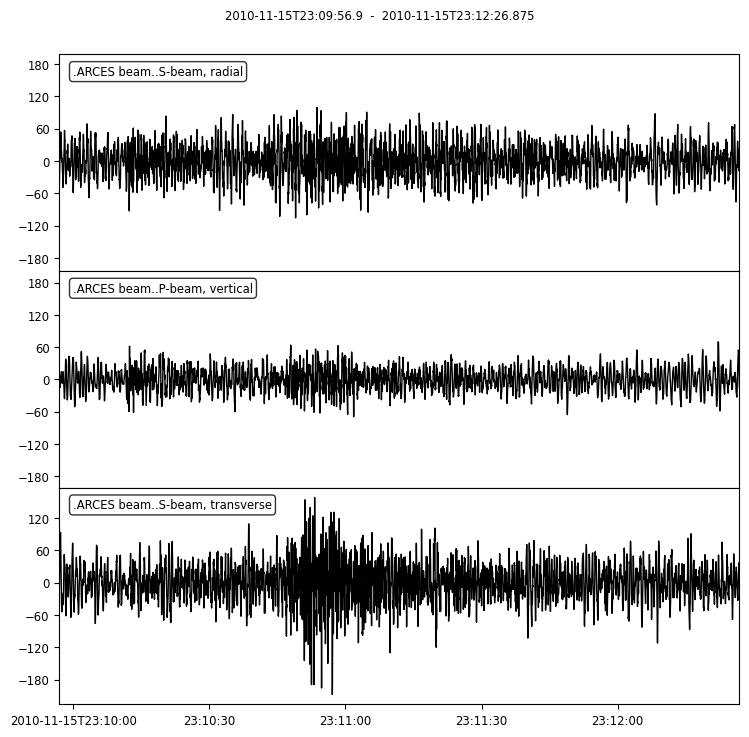

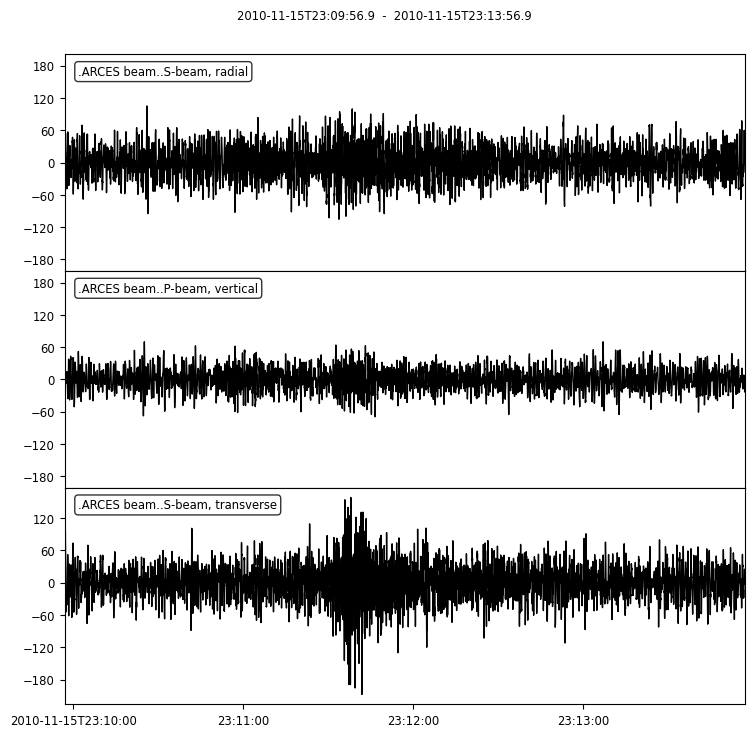

In [102]:
i +=1
sample_trace = train_trace[i]
sample_label = train_label[i]
print(sample_label)
print(sample_label, train_ds[:,1][i])
original_trace, sample_info = handler.path_to_trace(train_ds[i][0])
helper.plot_event(sample_trace, sample_info)
helper.plot_event(original_trace, sample_info)

In [11]:
sample_trace

array([[-19.1079998 , -10.9384594 , -12.63242245, ...,  10.91055107,
         10.39897346,  11.46795082],
       [-10.2228899 , -17.67623711, -14.31082249, ..., -27.05748749,
         -8.67001152,   7.00654316],
       [  1.35266352, -14.20997143, -24.97242546, ...,  19.54773903,
         22.88085365,  21.73709679]])

In [12]:
a = False
b = False
print(f"{'hello' if a else ''}")

In [13]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : True,
    'use_true_test_set' : False,
    'even_balance' : False
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded explosion and earthquake dataset:
As well as non train sets.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (20569, 0.5002)  |  explosion: (20554, 0.4998)  
Val ds:
earthquake: (3094, 0.5016)  |  explosion: (3074, 0.4984)  
Test ds:
earthquake: (2069, 0.5032)  |  explosion: (2043, 0.4968)  


In [14]:
train_ds

array([[ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2011-07-20T20.40.46.869000Z.h5',
        'explosion', 0],
       [ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2015-09-03T22.07.46.720000Z.h5',
        'explosion', 0],
       [ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-07-26T10.17.17.217000Z.h5',
        'explosion', 0],
       ..., 
       [ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2018-05-24T12.08.31.868000Z.h5',
        'explosion', 0],
       [ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2018-03-08T12.22.20.372000Z.h5',
        'explosion', 0],
       [ '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2013-11-08T19.40.18.536000Z.h5',
        'explosion', 0]], dtype=object)

In [15]:
print(np.unique(train_ds[train_ds[:,1] == "earthquake"][:,2], return_counts = True))
print(np.unique(val_ds[val_ds[:,1] == "earthquake"][:,2], return_counts = True))
print(np.unique(test_ds[test_ds[:,1] == "earthquake"][:,2], return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype=object), array([6625, 5562, 3932, 2384, 1206,  544,  222,   68,   18,    6,    1,
          1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object), array([990, 825, 584, 370, 193,  86,  31,   9,   4,   1,   1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object), array([665, 554, 392, 240, 120,  56,  23,  10,   4,   3,   2]))
